In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy.io import loadmat
from sklearn import svm
from sklearn.metrics import accuracy_score

%matplotlib inline

In [4]:
data=loadmat('data/ex6data1.mat')
X, y = data['X'], data['y'][:,0]
m=y.size

source code: https://github.com/dibgerge/ml-coursera-python-assignments/blob/master/Exercise6/exercise6.ipynb

In [35]:
def plotData(X, y, grid=False):
    """
    Plots the data points X and y into a new figure. Uses `+` for positive examples, and `o` for
    negative examples. `X` is assumed to be a Mx2 matrix
    Parameters
    ----------
    X : numpy ndarray
        X is assumed to be a Mx2 matrix.
    y : numpy ndarray
        The data labels.
    grid : bool (Optional)
        Specify whether or not to show the grid in the plot. It is False by default.
        
    """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    plt.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    plt.grid(grid)
    
    
def svmTrain(X, Y, C, kernelFunction, tol=1e-3, max_passes=5, args=()):
    """
    Trains an SVM classifier using a  simplified version of the SMO algorithm.
    Parameters
    ---------
    X : numpy ndarray
        (m x n) Matrix of training examples. Each row is a training example, and the
        jth column holds the jth feature.
    Y : numpy ndarray
        (m, ) A vector (1-D numpy array) containing 1 for positive examples and 0 for negative examples.
    C : float
        The standard SVM regularization parameter.
    kernelFunction : func
        A function handle which computes the kernel. The function should accept two vectors as
        inputs, and returns a scalar as output.
    tol : float, optional
        Tolerance value used for determining equality of floating point numbers.
    max_passes : int, optional
        Controls the number of iterations over the dataset (without changes to alpha)
        before the algorithm quits.
    args : tuple
        Extra arguments required for the kernel function, such as the sigma parameter for a
        Gaussian kernel.
    Returns
    -------
    model :
        The trained SVM model.
    Notes
    -----
    This is a simplified version of the SMO algorithm for training SVMs. In practice, if
    you want to train an SVM classifier, we recommend using an optimized package such as:
    - LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    - SVMLight (http://svmlight.joachims.org/)
    - scikit-learn (http://scikit-learn.org/stable/modules/svm.html) which contains python wrappers
    for the LIBSVM library.
    """
    # make sure data is signed int
    Y = Y.astype(int)
    # Dataset size parameters
    m, n = X.shape

    passes = 0
    E = np.zeros(m)
    alphas = np.zeros(m)
    b = 0

    # Map 0 to -1
    Y[Y == 0] = -1

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will **not** do this)

    # We have implemented the optimized vectorized version of the Kernels here so
    # that the SVM training will run faster
    if kernelFunction.__name__ == 'linearKernel':
        # Vectorized computation for the linear kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = np.dot(X, X.T)
    elif kernelFunction.__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X2 = np.sum(X**2, axis=1)
        K = X2 + X2[:, None] - 2 * np.dot(X, X.T)

        if len(args) > 0:
            K /= 2*args[0]**2

        K = np.exp(-K)
    else:
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i, j] = kernelFunction(X[i, :], X[j, :])
                K[j, i] = K[i, j]

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            E[i] = b + np.sum(alphas * Y * K[:, i]) - Y[i]

            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):
                # select the alpha_j randomly
                j = np.random.choice(list(range(i)) + list(range(i+1, m)), size=1)[0]

                E[j] = b + np.sum(alphas * Y * K[:, j]) - Y[j]

                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]

                # objective function positive definite, there will be a minimum along the direction
                # of linear equality constrain, and eta will be greater than zero
                # we are actually computing -eta here (so we skip of eta >= 0)
                if eta >= 0:
                    continue

                alphas[j] -= Y[j] * (E[i] - E[j])/eta
                alphas[j] = max(L, min(H, alphas[j]))

                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                alphas[i] += Y[i]*Y[j]*(alpha_j_old - alphas[j])

                b1 = b - E[i] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[i, j]

                b2 = b - E[j] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[j, j]

                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2

                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    idx = alphas > 0
    model = {'X': X[idx, :],
             'y': Y[idx],
             'kernelFunction': kernelFunction,
             'b': b,
             'args': args,
             'alphas': alphas[idx],
             'w': np.dot(alphas * Y, X)}
    return model
def svmPredict(model, X):
    """
    Returns a vector of predictions using a trained SVM model.
    Parameters
    ----------
    model : dict
        The parameters of the trained svm model, as returned by the function svmTrain
    X : array_like
        A (m x n) matrix where each example is a row.
    Returns
    -------
    pred : array_like
        A (m,) sized vector of predictions {0, 1} values.
    """
    # check if we are getting a vector. If so, then assume we only need to do predictions
    # for a single example
    if X.ndim == 1:
        X = X[np.newaxis, :]

    m = X.shape[0]
    p = np.zeros(m)
    pred = np.zeros(m)

    if model['kernelFunction'].__name__ == 'linearKernel':
        # we can use the weights and bias directly if working with the linear kernel
        p = np.dot(X, model['w']) + model['b']
    elif model['kernelFunction'].__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X1 = np.sum(X**2, 1)
        X2 = np.sum(model['X']**2, 1)
        K = X2 + X1[:, None] - 2 * np.dot(X, model['X'].T)

        if len(model['args']) > 0:
            K /= 2*model['args'][0]**2

        K = np.exp(-K)
        p = np.dot(K, model['alphas']*model['y']) + model['b']
    else:
        # other non-linear kernel
        for i in range(m):
            predictions = 0
            for j in range(model['X'].shape[0]):
                predictions += model['alphas'][j] * model['y'][j] \
                               * model['kernelFunction'](X[i, :], model['X'][j, :])
            p[i] = predictions

    pred[p >= 0] = 1
    return pred

def visualizeBoundaryLinear(X, y, model):
    """
    Plots a linear decision boundary learned by the SVM.
    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).
    y : array_like
        (m, ) The data labels.
    model : dict
        Dictionary of model variables learned by SVM.
    """
    w, b = model['w'], model['b']
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    plt.plot(xp, yp, '-b')

def visualizeBoundary(X, y, model):
    """
    Plots a non-linear decision boundary learned by the SVM and overlays the data on it.
    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).
    y : array_like
        (m, ) The data labels.
    model : dict
        Dictionary of model variables learned by SVM.
    """
    plotData(X, y)

    # make classification predictions over a grid of values
    x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)

    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = svmPredict(model, this_X)

    plt.contour(X1, X2, vals, colors='y', linewidths=2)
    plt.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
    plt.grid(False)
    
def linearKernel(x1, x2):
    """
    Returns a linear kernel between x1 and x2.
    Parameters
    ----------
    x1 : numpy ndarray
        A 1-D vector.
    x2 : numpy ndarray
        A 1-D vector of same size as x1.
    Returns
    -------
    : float
        The scalar amplitude.
    """
    return np.dot(x1, x2)

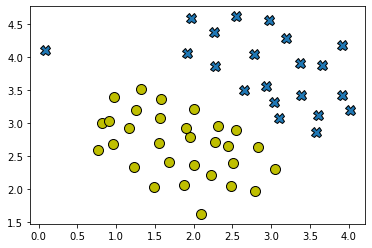

In [10]:
plotData(X,y)

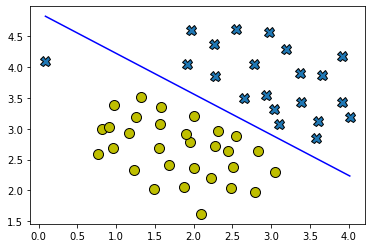

In [24]:
C = 1
model = svmTrain(X, y, C, linearKernel, 1e-3, 20)
visualizeBoundaryLinear(X, y, model)


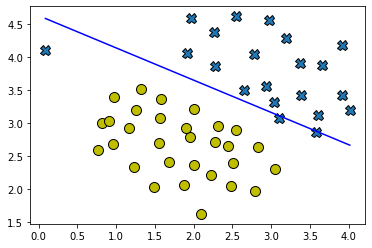

In [25]:
C = 10
model2 = svmTrain(X, y, C, linearKernel, 1e-3, 20)
visualizeBoundaryLinear(X, y, model2)

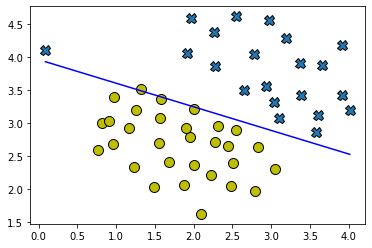

In [26]:
C = 100
model3 = svmTrain(X, y, C, linearKernel, 1e-3, 20)
visualizeBoundaryLinear(X, y, model3)

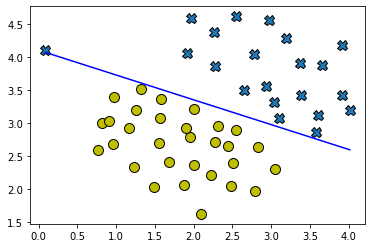

In [27]:
C = 1000
model4 = svmTrain(X, y, C, linearKernel, 1e-3, 20)
visualizeBoundaryLinear(X, y, model4)

In [28]:
def gaussianKernel(x1, x2, sigma):
    """
    Computes the radial basis function
    Returns a radial basis function kernel between x1 and x2.
    
    Parameters
    ----------
    x1 :  numpy ndarray
        A vector of size (n, ), representing the first datapoint.
    
    x2 : numpy ndarray
        A vector of size (n, ), representing the second datapoint.
    
    sigma : float
        The bandwidth parameter for the Gaussian kernel.

    Returns
    -------
    sim : float
        The computed RBF between the two provided data points.
    
    """
    sim = 0
    sim = np.exp(-np.sum((x1 - x2)**2)/(2*(sigma**2)))
    return sim

In [29]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



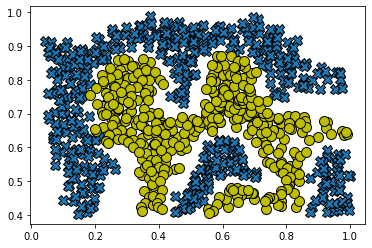

In [47]:
data = loadmat('data/ex6data2.mat')
X, y = data['X'], data['y'][:, 0]

# Plot training data
plotData(X, y)

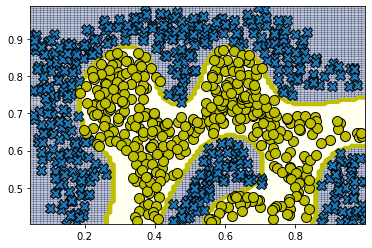

In [36]:
# SVM Parameters
C = 1
sigma = 0.1

model= svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)

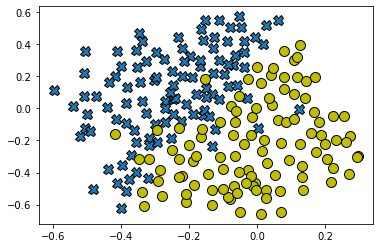

In [44]:
data = loadmat('data/ex6data3.mat')
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

# Plot training data
plotData(X, y)

In [45]:
def dataset3Params(X, y, Xval, yval):
    """
    Returns your choice of C and sigma for Part 3 of the exercise 
    where you select the optimal (C, sigma) learning parameters to use for SVM
    with RBF kernel.
    
    Parameters
    ----------
    X : array_like
        (m x n) matrix of training data where m is number of training examples, and 
        n is the number of features.
    
    y : array_like
        (m, ) vector of labels for ther training data.
    
    Xval : array_like
        (mv x n) matrix of validation data where mv is the number of validation examples
        and n is the number of features
    
    yval : array_like
        (mv, ) vector of labels for the validation data.
    
    Returns
    -------
    C, sigma : float, float
        The best performing values for the regularization parameter C and 
        RBF parameter sigma.
    
    Instructions
    ------------
    Fill in this function to return the optimal C and sigma learning 
    parameters found using the cross validation set.
    You can use `svmPredict` to predict the labels on the cross
    validation set. For example, 
    
        predictions = svmPredict(model, Xval)

    will return the predictions on the cross validation set.
    
    Note
    ----
    You can compute the prediction error using 
    
        np.mean(predictions != yval)
    """
    # You need to return the following variables correctly.
    C = [0.01,0.03,0.1,0.3,1,3,10,30]
    Sigma = [0.01,0.03,0.1,0.3,1,3,10,30]
    accuracy_scores = []
  
    for c in C:
        for sigma in Sigma:
            model = svmTrain(X, y, c, gaussianKernel, args=(sigma,))
            y_pred = svmPredict(model, Xval)
            accuracy_scores.append(accuracy_score(yval, y_pred))

    max_acr = np.argmax(accuracy_scores) + 1
    c_len = len(C)
    s_len = len(Sigma)

    C_opt = C[int(max_acr/s_len)]
    Sigma_opt = Sigma[max_acr%s_len - 1]
    return C, sigma

In [ ]:
C, sigma = dataset3Params(X, y, Xval, yval)

# Train the SVM
# model = utils.svmTrain(X, y, C, lambda x1, x2: gaussianKernel(x1, x2, sigma))
model = svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)
print(C, sigma)